# Deep Learning - Mini Project 1
---------

### Load the modules and prepare the notebook

In [3]:
# Load necessary modules

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from jupyterthemes import jtplot
import seaborn as sns
import random

import matplotlib.patches as patches

import keras
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import concatenate
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.engine.input_layer import Input
from sklearn.preprocessing import StandardScaler

Using TensorFlow backend.


In [4]:
# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline
jtplot.reset()
sns.set()

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 100

/Users/alexandrelandeau/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/alexandrelandeau/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/alexandrelandeau/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


### Getting Started

In [5]:
def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

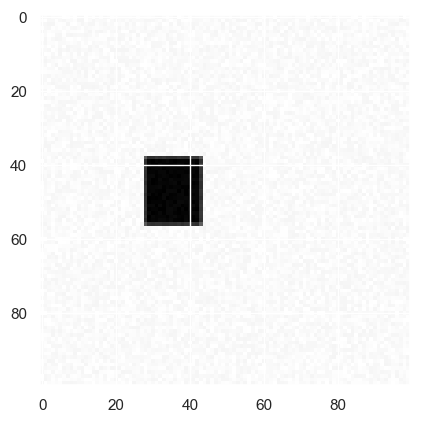

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

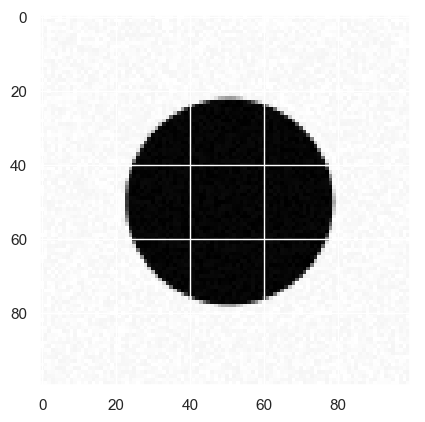

In [7]:
im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

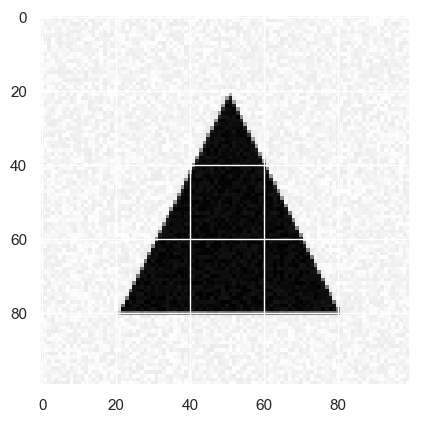

In [8]:
[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
plt.show()

In [9]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

### Question 3 - Simple Classification

In [460]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


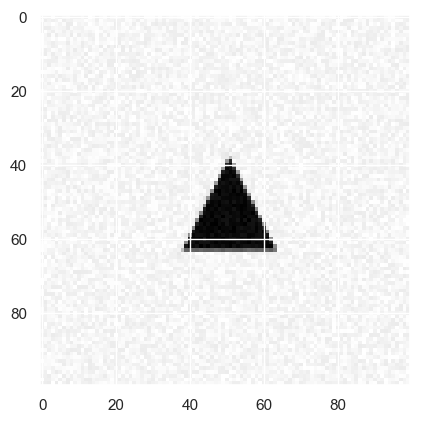

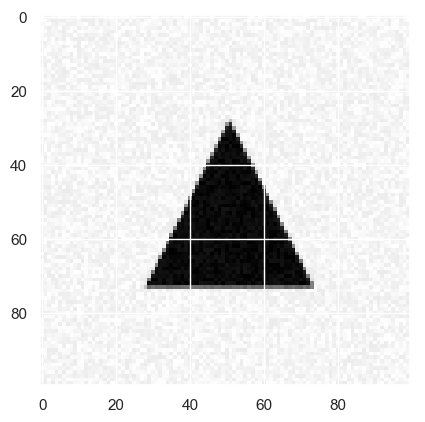

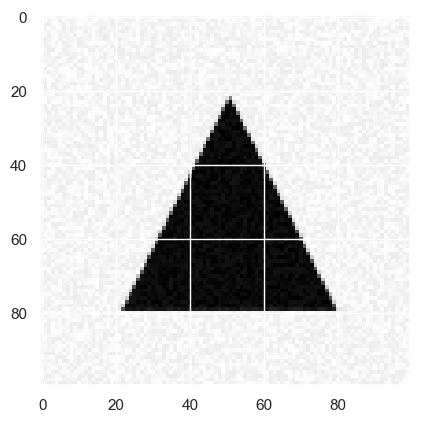

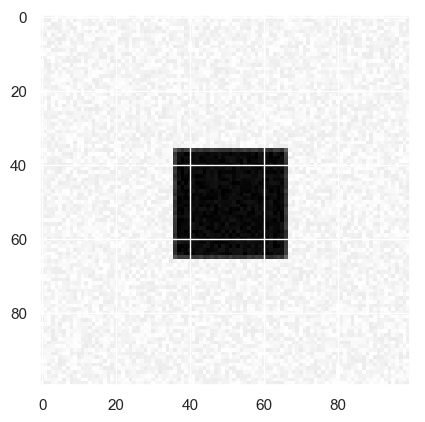

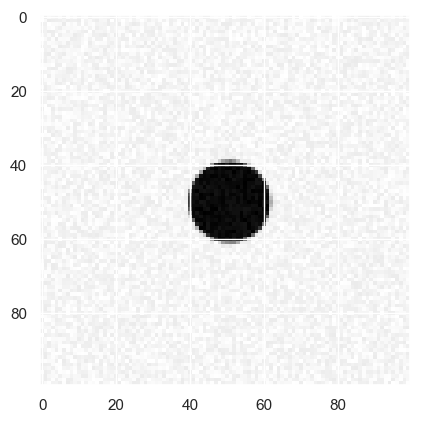

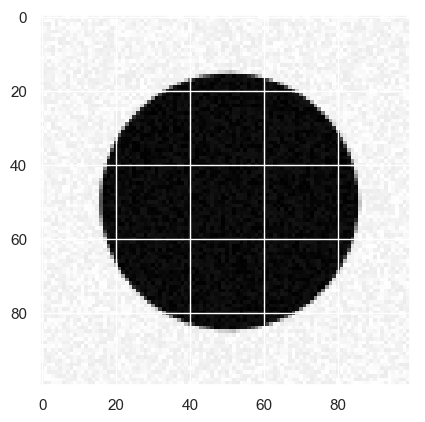

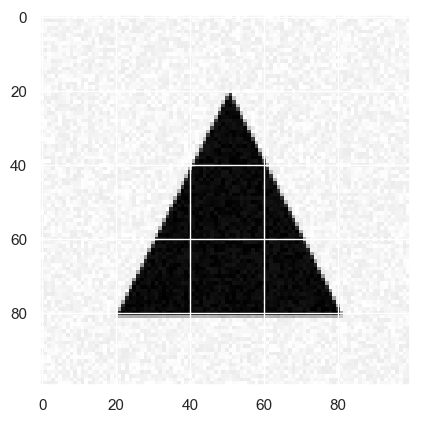

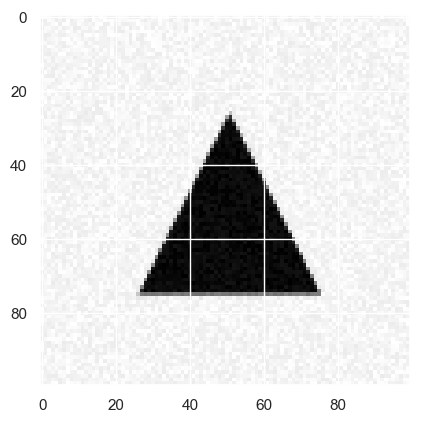

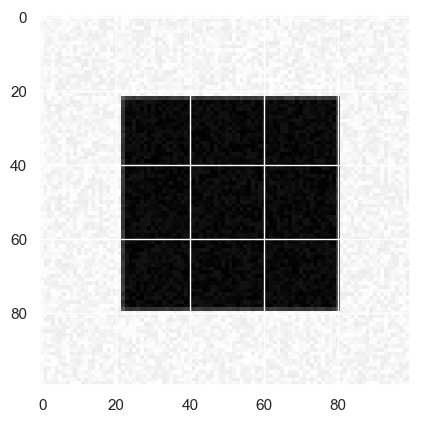

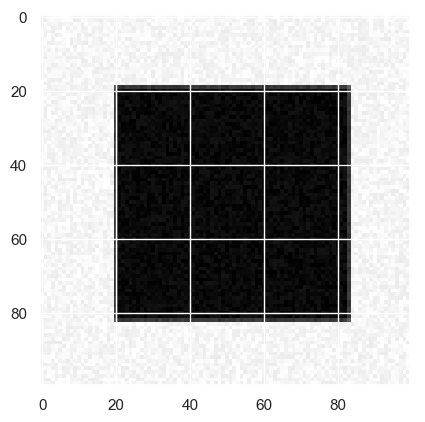

In [179]:
for i in range(1, 100, 10):
    plt.figure()
    plt.imshow(X_train[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

In [463]:
# Generate target by making Y_train a categorical

target = to_categorical(Y_train)

In [466]:
# Create a Neural Network with Gradient Descent Optimizer

n_cols = X_train.shape[1]

model_GradDesc = Sequential()
model_GradDesc.add(Dense(3, activation='softmax', input_shape=(n_cols,)))
model_GradDesc.compile(loss = 'categorical_crossentropy', optimizer = 'sgd')

In [467]:
# Fit the Neural Network

early_stopping_monitor = EarlyStopping(patience = 10)

model_GradDesc.fit(X_train, target, validation_split = 0.3, batch_size = 32, 
                   epochs = 50, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/50
210/210 [==============================] - 1s 5ms/step - loss: 9.8548 - val_loss: 10.5663
Epoch 2/50
210/210 [==============================] - 0s 128us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 3/50
210/210 [==============================] - 0s 168us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 4/50
210/210 [==============================] - 0s 164us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 5/50
210/210 [==============================] - 0s 150us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 6/50
210/210 [==============================] - 0s 180us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 7/50
210/210 [==============================] - 0s 169us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 8/50
210/210 [==============================] - 0s 147us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 9/50
210/210 [==============================] - 0s 166us/step - loss: 11.2059 - val_loss: 10.5663
Epoch 10/50
210/210 [=

In [469]:
# Create a Neural Network with Adam Optimizer

n_cols = X_train.shape[1]

model_Adam = Sequential()
model_Adam.add(Dense(3, activation='softmax', input_shape=(n_cols,)))
model_Adam.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

In [470]:
# Fit the Neural Network

early_stopping_monitor = EarlyStopping(patience = 10)

model_Adam.fit(X_train, target, validation_split = 0.3, batch_size = 32, 
                   epochs = 50, callbacks = [early_stopping_monitor])

Train on 210 samples, validate on 90 samples
Epoch 1/50
210/210 [==============================] - 1s 6ms/step - loss: 3.9615 - val_loss: 1.2085
Epoch 2/50
210/210 [==============================] - 0s 159us/step - loss: 1.7307 - val_loss: 1.7325
Epoch 3/50
210/210 [==============================] - 0s 190us/step - loss: 1.2781 - val_loss: 0.5277
Epoch 4/50
210/210 [==============================] - 0s 177us/step - loss: 0.9184 - val_loss: 0.6423
Epoch 5/50
210/210 [==============================] - 0s 181us/step - loss: 0.6193 - val_loss: 0.5632
Epoch 6/50
210/210 [==============================] - 0s 210us/step - loss: 0.4247 - val_loss: 0.3744
Epoch 7/50
210/210 [==============================] - 0s 212us/step - loss: 0.3473 - val_loss: 0.4803
Epoch 8/50
210/210 [==============================] - 0s 194us/step - loss: 0.5089 - val_loss: 0.2703
Epoch 9/50
210/210 [==============================] - 0s 189us/step - loss: 0.2824 - val_loss: 0.2650
Epoch 10/50
210/210 [==================

We observe than the Adam optimizer is way better than the stochastic gradient descent as it converges fast and improves dramatically the perfprmance of the model. On the opposite the stochastic gradient descent optimizer seems to not manage to converge.

### Question 4 - Visualisation of the Solution

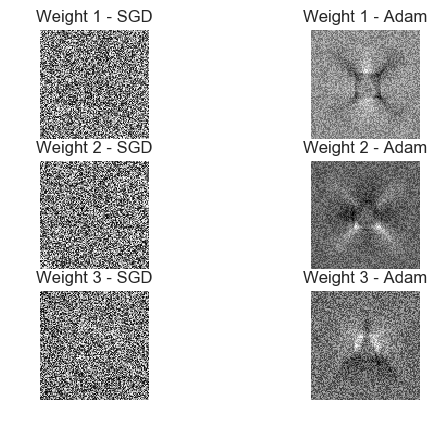

In [472]:
# Extract the weights of each model

plt.subplots(3, 2)

#model_GradDesc.get_weights()[0].shape
for i in range(3):
    plt.subplot(3,2,2*i +1)
    plt.imshow(model_GradDesc.get_weights()[0][:,i].reshape(100,100), cmap='gray')
    plt.axis('Off')
    plt.title('Weight ' + str(i+1) + ' - SGD')

for i in range(3):
    plt.subplot(3,2,(2*i +2))
    plt.imshow(model_Adam.get_weights()[0][:,i].reshape(100,100), cmap='gray')
    plt.axis('Off')
    plt.title('Weight ' + str(i+1)+ ' - Adam')

plt.show()

We return the weights for each category a nd for each optimizer. As the stochastic gradient descent optimizer doesn't allow the model to fit well the data, the weights look like gaussian noise. On the other hand, for the Adam optimizer, which converges well, we can observe that the network detects specific features for each shape: for a rectangle the model detects the 4 corners, for a circle the model doesn't detect corners, and for the triangle the model detects 3 corners, two at the bottom and one at the top of the shape.

### Question 5 - A More Difficult Classification Problem 

In [10]:
# Generate the data
n_obs = 3000

[X_train, Y_train] = generate_dataset_classification(n_obs, 20, True)

target = to_categorical(Y_train)

[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

In [200]:
# Create a Neural Network with Adam Optimizer

n_cols = X_train.shape[1]

model_Adam = Sequential()
model_Adam.add(Dense(3, activation='softmax', input_shape=(n_cols,)))
model_Adam.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [202]:
# Fit the Neural Network

early_stopping_monitor = EarlyStopping(patience = 3)

model_Adam.fit(X_train, target, validation_split = 0.3, batch_size = 32, 
                   epochs = 20, callbacks = [early_stopping_monitor])

Train on 2100 samples, validate on 900 samples
Epoch 1/20
2100/2100 [==============================] - 0s 193us/step - loss: 5.8176 - acc: 0.3881 - val_loss: 5.9786 - val_acc: 0.3644
Epoch 2/20
2100/2100 [==============================] - 0s 187us/step - loss: 5.9693 - acc: 0.3576 - val_loss: 6.6196 - val_acc: 0.3411
Epoch 3/20
2100/2100 [==============================] - 0s 186us/step - loss: 6.0113 - acc: 0.3786 - val_loss: 6.4338 - val_acc: 0.3411
Epoch 4/20
2100/2100 [==============================] - 0s 189us/step - loss: 5.9947 - acc: 0.3610 - val_loss: 6.0254 - val_acc: 0.3433


In [203]:
model_Adam.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 75us/step


[6.373956298828125, 0.3433333333333333]

In [204]:
# Create a Convolutional Neural Network with Adam Optimizer

convnet = Sequential()
convnet.add(Conv2D(16, (5,5), input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1),activation=None))
convnet.add(MaxPooling2D(pool_size=(5,5), padding='same'))
convnet.add(Flatten())
convnet.add(Dense(100, activation='relu'))
convnet.add(Dense(3, activation='softmax'))
convnet.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [205]:
# Fit the Neural Network
conv_train = X_train.reshape(n_obs, IMAGE_SIZE, IMAGE_SIZE, 1)
early_stopping_monitor = EarlyStopping(patience = 3)

convnet.fit(conv_train, target, validation_split = 0.3, batch_size = 32, 
            epochs = 20, callbacks = [early_stopping_monitor])

Train on 2100 samples, validate on 900 samples
Epoch 1/20
2100/2100 [==============================] - 6s 3ms/step - loss: 1.0135 - acc: 0.5181 - val_loss: 0.8136 - val_acc: 0.6822
Epoch 2/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.7551 - acc: 0.6581 - val_loss: 0.7411 - val_acc: 0.6489
Epoch 3/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.6681 - acc: 0.6971 - val_loss: 0.6401 - val_acc: 0.7044
Epoch 4/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.6086 - acc: 0.7167 - val_loss: 0.6055 - val_acc: 0.7533
Epoch 5/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.5353 - acc: 0.7624 - val_loss: 0.5640 - val_acc: 0.7700
Epoch 6/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.4620 - acc: 0.8090 - val_loss: 0.4855 - val_acc: 0.7978
Epoch 7/20
2100/2100 [==============================] - 4s 2ms/step - loss: 0.4034 - acc: 0.8476 - val_loss: 0.4743 - val_acc: 0.8200
Epoch 8/20
2100

In [206]:
convnet.evaluate(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 0s 336us/step


[0.3330407285690308, 0.8833333325386047]

When it comes to shape recognition, we observe that both our models overfit. We reduced overfitting and improved performance by generating 3000 images rather than 300 but both models still have some overfitting. 

The linear classifier doesn't perform well at all, we see that the convolutionnal network is way better at dealing with images, as it has a lot more tunable parameters than the linear model and because convolutions allow the model to identify patterns in the images

### Question 6 - A Regression Problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2

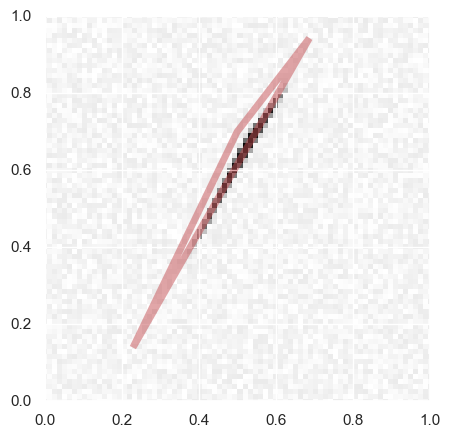

In [20]:
# Generate the data
regression_obs=3000

[X_train, Y_train] = generate_dataset_regression(regression_obs, 20)

# Create the test sets

[X_test, Y_test] = generate_test_set_regression()

# Scale Y_train and Y_test

scaler = StandardScaler(with_mean=True, with_std=True)

scaler.fit_transform(Y_train)
scaler.transform(Y_test)

visualize_prediction(X_train[0], Y_train[0])

regression_train = X_train.reshape(regression_obs, IMAGE_SIZE, IMAGE_SIZE, 1)

We sort the vertices by x coordinate to reduce randomness in the model training

In [21]:
def sort(array):
    x1, y1, x2, y2, x3, y3 = array
    array_sorted = sorted([[x1, y1], [x2, y2], [x3, y3]], key=lambda x: x[0])
    array_sorted = np.reshape(array_sorted, -1).T
    array_sorted = np.array(array_sorted)
    return array_sorted

In [22]:
for i in range(Y_train.shape[0]):
    Y_train[i] = sort(Y_train[i])
    
for i in range(Y_test.shape[0]):
    Y_test[i] = sort(Y_test[i])

We used a model based on the AlexNet architecture, made for image classification. We fitted the model through a maximum of 100 epochs, with an early stopping monitor with a patience of 10

In [23]:
model = Sequential()
model.add(BatchNormalization(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
model.add(Conv2D(6, (5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(16, (5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(26, (5,5), padding='valid', activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(120, activation='relu'))
model.add(Dense(84, activation='relu'))
model.add(Dense(6))

In [24]:
model.compile(loss = 'mse', optimizer = 'adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 100, 100, 1)       4         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 96, 96, 6)         156       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 6)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 44, 44, 16)        2416      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 18, 18, 26)        10426     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 9, 9, 26)          0         
__________

In [29]:
# Fit the model

early_stopping_monitor = EarlyStopping(patience = 10)

model.fit(regression_train, Y_train, validation_split = 0.3, batch_size = 32, 
            epochs = 100, callbacks = [early_stopping_monitor])

Train on 2100 samples, validate on 900 samples
Epoch 1/100
2100/2100 [==============================] - 12s 6ms/step - loss: 0.0021 - val_loss: 0.0088
Epoch 2/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0020 - val_loss: 0.0081
Epoch 3/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0020 - val_loss: 0.0091
Epoch 4/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 5/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0021 - val_loss: 0.0087
Epoch 6/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0021 - val_loss: 0.0086
Epoch 7/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0019 - val_loss: 0.0087
Epoch 8/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0020 - val_loss: 0.0085
Epoch 9/100
2100/2100 [==============================] - 11s 5ms/step - loss: 0.0019 - val_loss: 0.0089
Epoch 10/100
2100

In [30]:
# Evaluate the model

model.evaluate(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1), Y_test)

300/300 [==============================] - 1s 2ms/step


0.009448980093002319

In [31]:
# Generate Predictions

Y_pred_model = model.predict(X_test.reshape(X_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1))

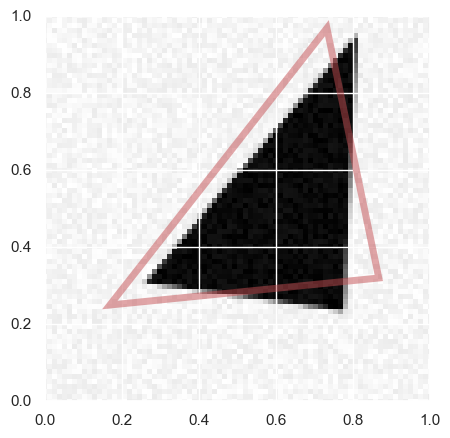

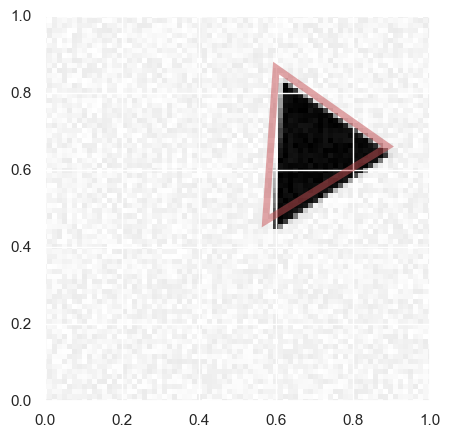

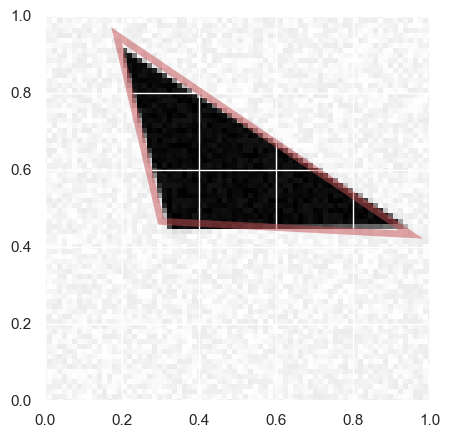

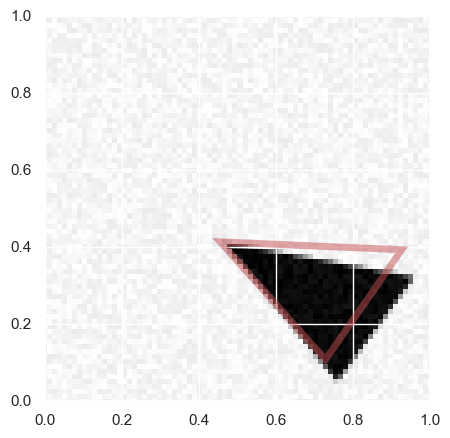

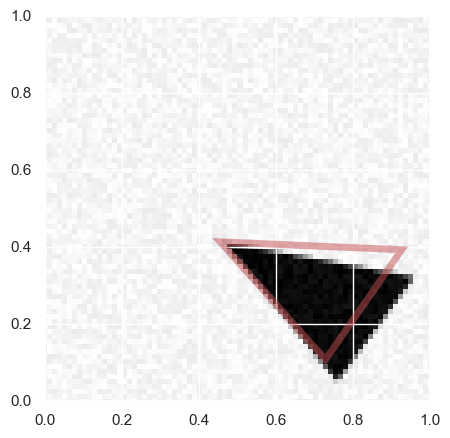

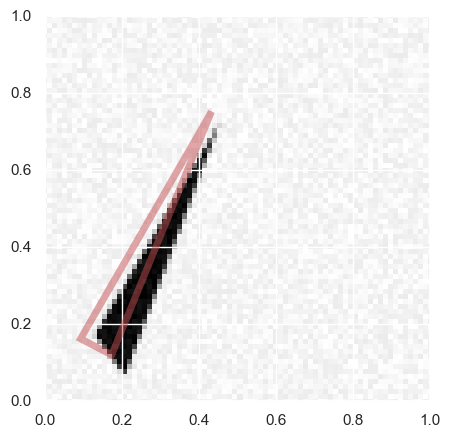

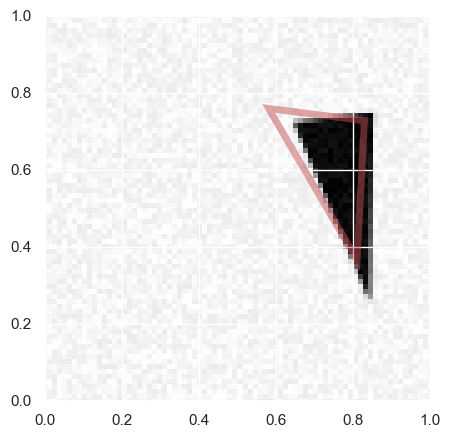

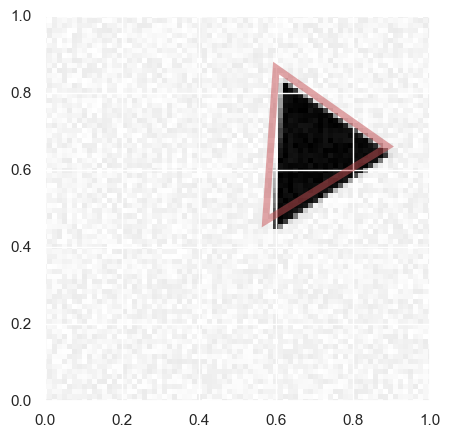

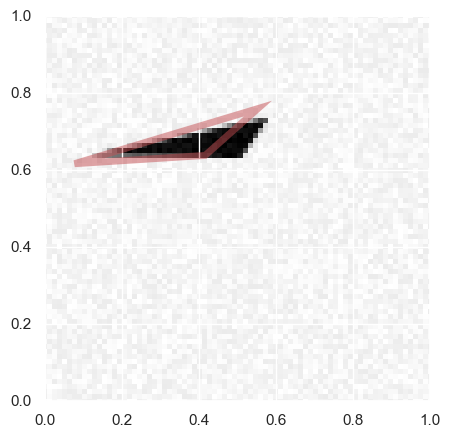

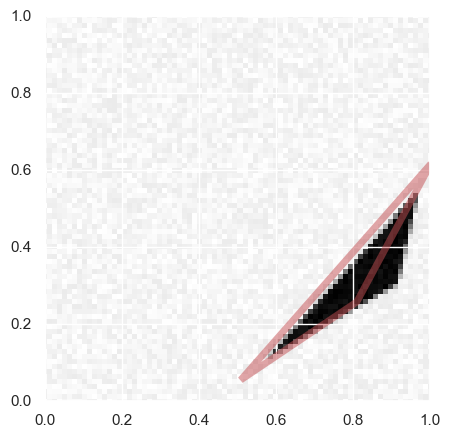

In [32]:
# Visualize predictions

for i in range(10):
    j = random.randint(0, 299)
    visualize_prediction(X_test[j], Y_pred_model[j])

With a mean squared error of 0.009 we managed to achieve good results, which are confirmed by visualizing the predictions. The most effective improvement we found for the model was to increase depth by adding convolution layers, which allow the model to identify better edges and corners.
We also improved greately the model when we sorted all the vertices by x axis. In fact, by reducing the randomness in the target, the model trains better and converges faster. We also improved the convergence by adding Batch Normalization in the model.
Finally, we observe that we have pratically no overfit as the performance on the train and validation sets barely doesn't change.

### Question 7 - Image Denoising

We created a U-Net as theorized by Olaf Ronneberger, Philipp Fischer and Thomas Brox. However, this network is too big to be trained on our computer. So after the code of the U-Net, we created a smaller U-Net to be able to train it and produce results.

#### Generate Noisy Data of size 512x512

We modify the data generation functions so that they return two versions of each image: one without noise and one with noise with 100 variance.

In [3]:
def generate_a_noisy_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_noisy_rectangle(noise=0.0, free_location=False):
    figsize = 5.12 
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)*figsize
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_noisy_drawing(figsize, U, V), generate_a_noisy_drawing(figsize, U, V, noise)

def generate_a_noisy_disk(noise=0.0, free_location=False):
    figsize = 5.12
    if free_location:
        center = np.random.random(2)*figsize
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_noisy_drawing(figsize, U, V), generate_a_noisy_drawing(figsize, U, V, noise)

def generate_a_noisy_triangle(noise=0.0, free_location=False):
    figsize = 5.12
    if free_location:
        U = np.random.random(3)*figsize
        V = np.random.random(3)*figsize
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_noisy_drawing(figsize, U, V)
    imdata_noisy = generate_a_noisy_drawing(figsize, U, V, noise)
    return [imdata, imdata_noisy, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [86]:
# Define Image Size

IMAGE_SIZE_2 = 512

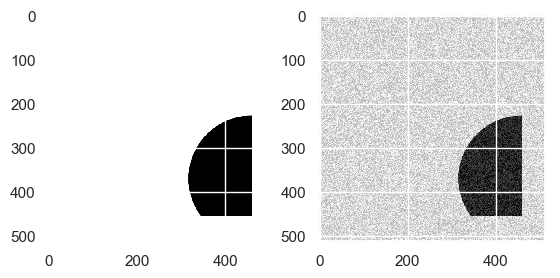

In [7]:
im1, im2 = generate_a_noisy_disk(100, free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(im1.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im2.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.show()

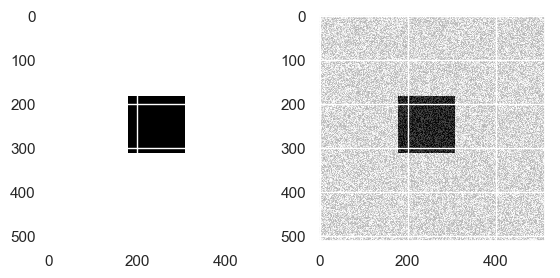

In [8]:
im1, im2 = generate_a_noisy_rectangle(100, free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(im1.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im2.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.show()

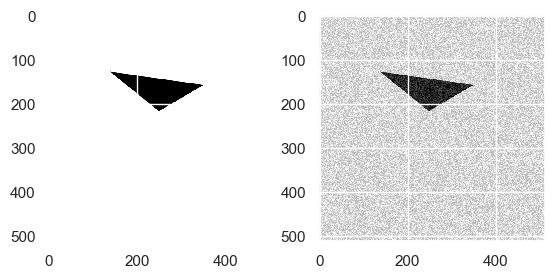

In [9]:
im1, im2, _ = generate_a_noisy_triangle(100, free_location=True)
plt.subplot(1, 2, 1)
plt.imshow(im1.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(im2.reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
plt.show()

In [12]:
def generate_dataset_denoising(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_noisy_rectangle()[0].shape[0]
    X = []
    Y = []
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            im1, im2 = generate_a_noisy_rectangle(noise, free_location)
            Y.append(im1)
            X.append(im2)
        elif category == 1: 
            im1, im2 = generate_a_noisy_disk(noise, free_location)
            Y.append(im1)
            X.append(im2)
        else:
            im1, im2, _ = generate_a_noisy_triangle(noise, free_location)
            Y.append(im1)
            X.append(im2)
    return X, Y

In [11]:
n_obs = 300
X_train, Y_train = generate_dataset_denoising(n_obs,100, free_location=True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [12]:
X_train = np.array([im.reshape(IMAGE_SIZE_2, IMAGE_SIZE_2, 1).copy() for im in X_train])
Y_train = np.array([im.reshape(IMAGE_SIZE_2, IMAGE_SIZE_2, 1).copy() for im in Y_train])

In [90]:
#Plot images from X_train and their target image

for i in range(1, 100, 10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X_train[i].reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train[i].reshape(IMAGE_SIZE_2,IMAGE_SIZE_2), cmap='gray')
    plt.show()

NameError: name 'X_train' is not defined

#### Create a U-Net for Denoising (too big to run on my computer)

The real U-Net can't work with images of size 100 x 100 because the max pooling layers divide image size by 2 each time and 100 can only be divided twice by 2. So I generated images of size 512 * 512. However, the network is too big to run on my computer (approximately 31 million parameters) so I created a smaller U-Net below to run it on 100 x 100 pictures with only 2 layers of Max Pooling.

In [87]:
# U-net

inputs = Input(shape=(IMAGE_SIZE_2,IMAGE_SIZE_2,1))

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1))(conv9)

u_net = Model(inputs=[inputs], outputs=[conv10])

In [88]:
u_net.compile(optimizer='adam', loss='mean_squared_error')

In [89]:
u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_120 (Conv2D)             (None, 512, 512, 64) 640         input_12[0][0]                   
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 512, 512, 64) 36928       conv2d_120[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 256, 256, 64) 0           conv2d_121[0][0]                 
__________________________________________________________________________________________________
conv2d_122

In [ ]:
early_stopping_monitor = EarlyStopping(patience = 10)

u_net.fit(X_train, Y_train, validation_split = 0.3, batch_size = 32, 
                   epochs = 50, callbacks = [early_stopping_monitor], verbose=2)

Train on 210 samples, validate on 90 samples
Epoch 1/50


#### Create smaller U-Net for images of size 100 x 100

Our smaller U-Net is made to be run with images of size 100 x 100 and uses only two layers of pooling before the decoding part.

In [3]:
IMAGE_SIZE = 100

In [4]:
# Create the network

inputs = Input(shape=(IMAGE_SIZE,IMAGE_SIZE,1))

conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)

up5 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv4), conv2], axis=3)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv1], axis=3)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)

conv7 = Conv2D(1, (1, 1))(conv6)

small_u_net = Model(inputs=[inputs], outputs=[conv7])

In [5]:
small_u_net.compile(optimizer='adam', loss='mean_squared_error')

In [6]:
small_u_net.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 100, 100, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 100, 100, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 50, 50, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

#### Generate noisy dataset of size 100 x 100

In [11]:
def generate_a_noisy_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_noisy_rectangle(noise=0.0, free_location=False):
    figsize = 1.0
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)*figsize
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_noisy_drawing(figsize, U, V), generate_a_noisy_drawing(figsize, U, V, noise)

def generate_a_noisy_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)*figsize
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_noisy_drawing(figsize, U, V), generate_a_noisy_drawing(figsize, U, V, noise)

def generate_a_noisy_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)*figsize
        V = np.random.random(3)*figsize
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_noisy_drawing(figsize, U, V)
    imdata_noisy = generate_a_noisy_drawing(figsize, U, V, noise)
    return [imdata, imdata_noisy, [U[0], V[0], U[1], V[1], U[2], V[2]]]

In [71]:
n_obs = 300

X_train_small, Y_train_small = generate_dataset_denoising(n_obs,100, free_location=True)

X_train_small = np.array([im.reshape(IMAGE_SIZE, IMAGE_SIZE, 1).copy() for im in X_train_small])
Y_train_small = np.array([im.reshape(IMAGE_SIZE, IMAGE_SIZE, 1).copy() for im in Y_train_small])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


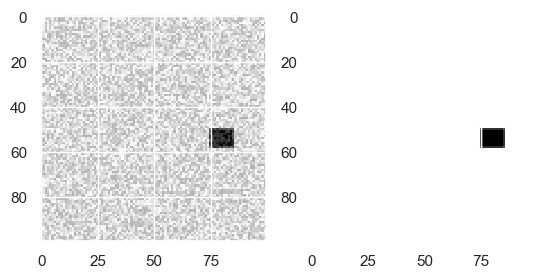

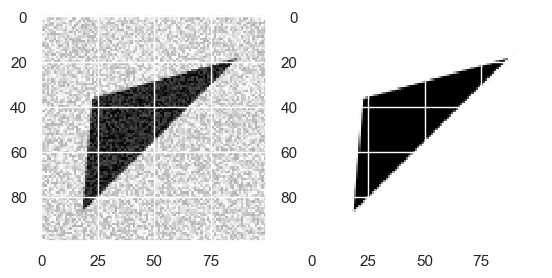

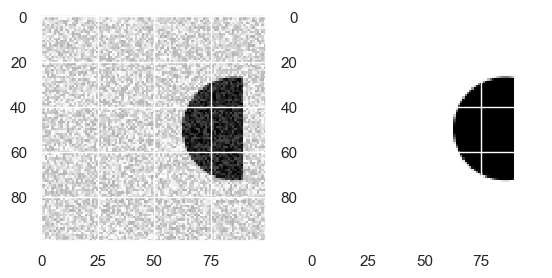

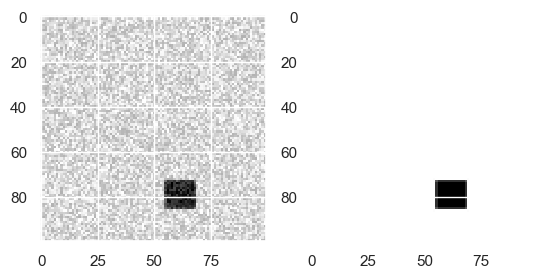

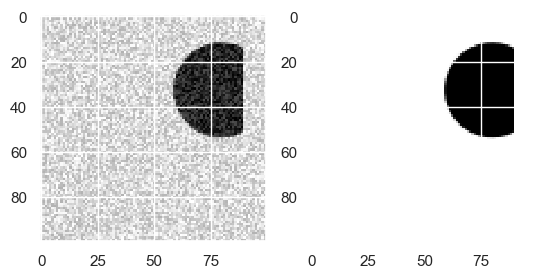

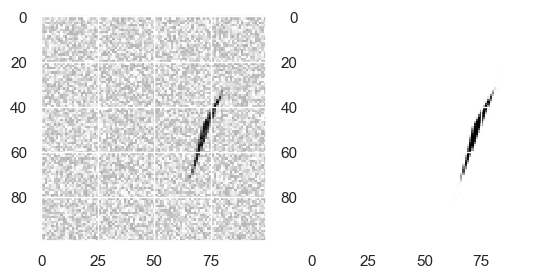

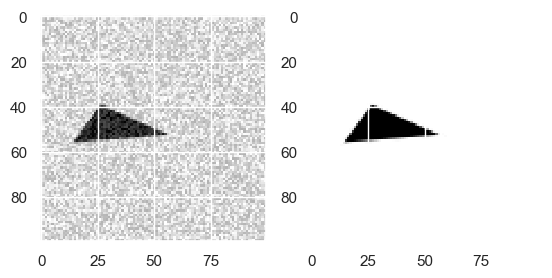

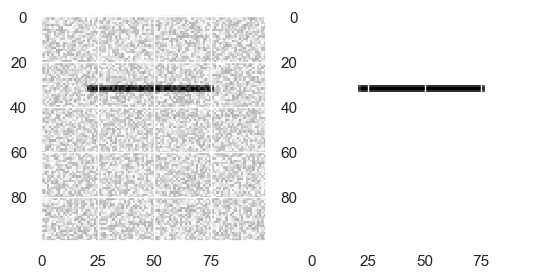

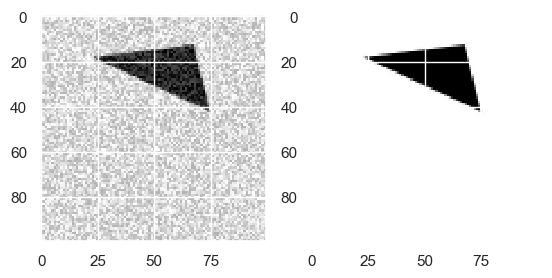

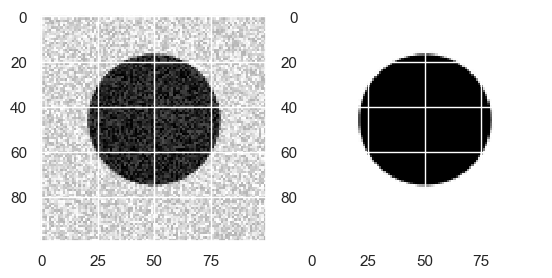

In [60]:
for i in range(1, 100, 10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X_train_small[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(Y_train_small[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

#### Generate test data of size 100 x 100

In [16]:
n_obs = 300
X_test_small, Y_test_small = generate_dataset_denoising(n_obs,100, free_location=True)

X_test_small = np.array([im.reshape(IMAGE_SIZE, IMAGE_SIZE, 1).copy() for im in X_test_small])
Y_test_small = np.array([im.reshape(IMAGE_SIZE, IMAGE_SIZE, 1).copy() for im in Y_test_small])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


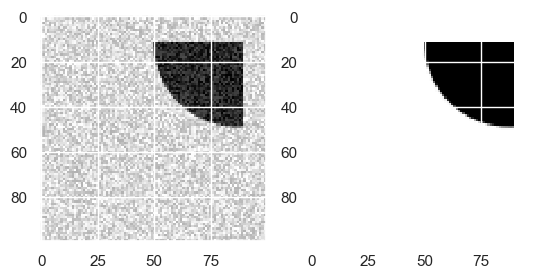

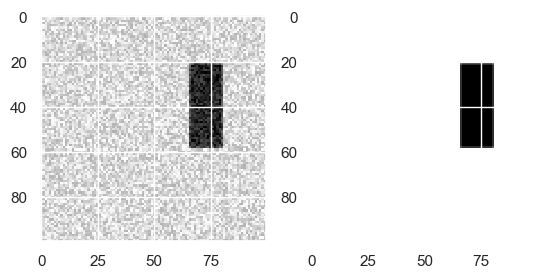

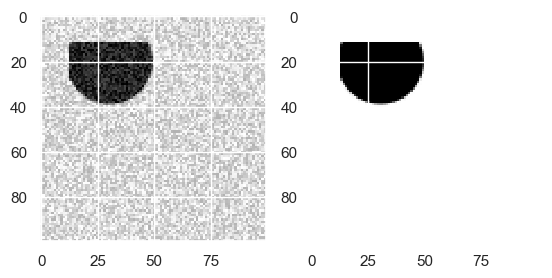

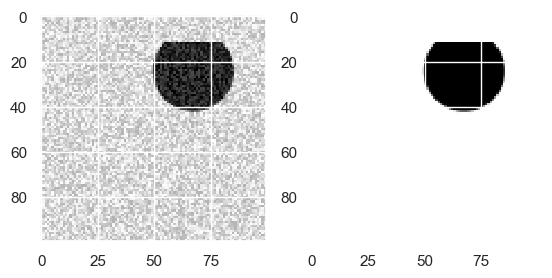

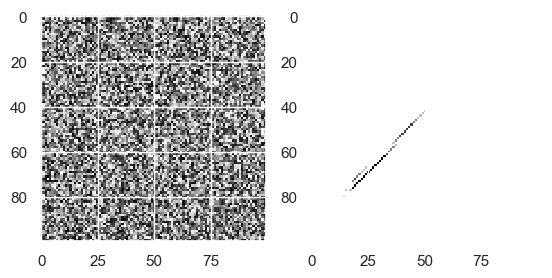

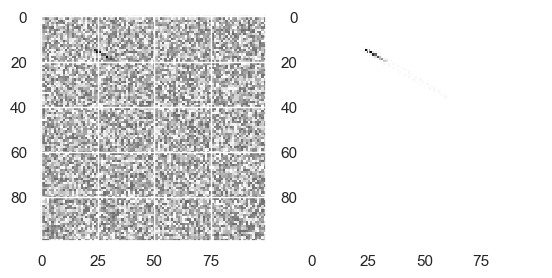

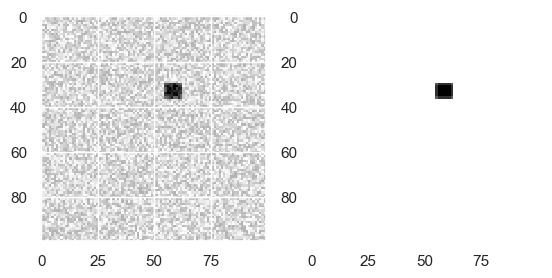

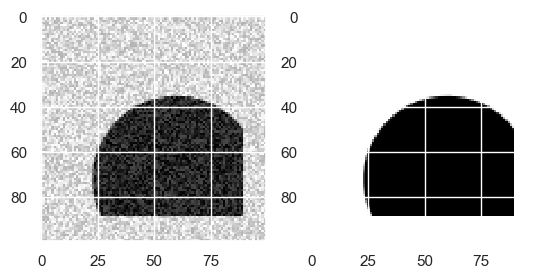

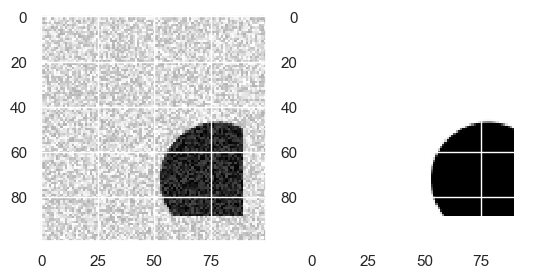

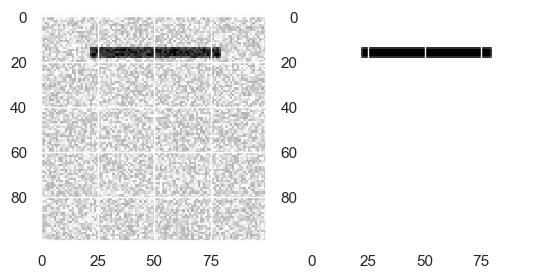

In [42]:
for i in range(1, 100, 10):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(X_test_small[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(Y_test_small[i].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')
    plt.show()

#### Fit the U-Net and Generate Denoising

In [148]:
# Fit the U-Net using at maximum 100 epochs with early stopping of patience 10

early_stopping_monitor = EarlyStopping(patience = 10)

small_u_net.fit(X_train_small, Y_train_small, validation_split = 0.3, batch_size = 32, 
                   epochs = 100, callbacks = [early_stopping_monitor], verbose=2)

Train on 210 samples, validate on 90 samples
Epoch 1/100
 - 51s - loss: 36121.6758 - val_loss: 17749.0468
Epoch 2/100
 - 47s - loss: 8070.0319 - val_loss: 3931.0916
Epoch 3/100
 - 49s - loss: 2673.4594 - val_loss: 1511.2632
Epoch 4/100
 - 47s - loss: 1308.3505 - val_loss: 943.9499
Epoch 5/100
 - 48s - loss: 867.7526 - val_loss: 751.3359
Epoch 6/100
 - 48s - loss: 558.4493 - val_loss: 516.1651
Epoch 7/100
 - 48s - loss: 386.3876 - val_loss: 339.0627
Epoch 8/100
 - 47s - loss: 254.9895 - val_loss: 238.7202
Epoch 9/100
 - 49s - loss: 185.7317 - val_loss: 158.7644
Epoch 10/100
 - 48s - loss: 139.9721 - val_loss: 130.4172
Epoch 11/100
 - 51s - loss: 105.6605 - val_loss: 100.5994
Epoch 12/100
 - 53s - loss: 83.0890 - val_loss: 82.1882
Epoch 13/100
 - 51s - loss: 69.1632 - val_loss: 68.1691
Epoch 14/100
 - 48s - loss: 59.3055 - val_loss: 58.9406
Epoch 15/100
 - 51s - loss: 52.2123 - val_loss: 52.5246
Epoch 16/100
 - 50s - loss: 47.2517 - val_loss: 47.8236
Epoch 17/100
 - 46s - loss: 43.5881 -

In [149]:
# Generate predictions

Y_pred_small = small_u_net.predict(X_test_small)

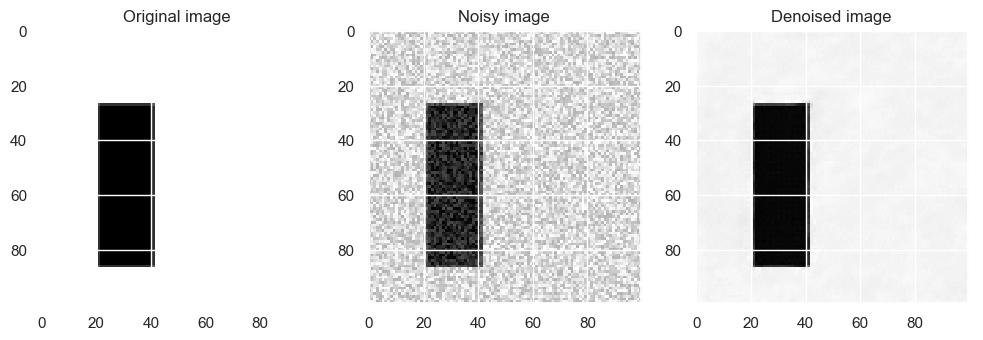

In [150]:
# Plot the results

plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(Y_test_small[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Original image')

plt.subplot(1, 3, 2)
plt.imshow(X_test_small[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Noisy image')

plt.subplot(1, 3, 3)
plt.imshow(Y_pred_small[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.title('Denoised image')

plt.tight_layout()
plt.show()

In [151]:
# Measure performance

small_u_net.evaluate(X_test_small, Y_test_small)

300/300 [==============================] - 24s 81ms/step


9.501453997294108

The deeper the convolutions get, the better the model becomes. As we had problems of overfitting, we increased the number of observations to reduce overfitting. We also decided to not use any activation function on the last layer, as the softmax function normaly used in a U-Net was setting every pixel to the value 255 and was preventing the model from 
converging.

With a MSE of 9.5, we achieved pretty good results, and the high number of parameters allowed us to produce very sharp outputs. Adding more depth to convolutions, also helped us avoid having outputs with lots of errors on the borders of the images.